In [1]:
import sys
import os

# Add project root to Python path
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Project root:", PROJECT_ROOT)


Project root: c:\Users\Poojitha\OneDrive\Desktop\Pneumonia-Detection-GradCAM


In [2]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from src.gradcam import make_gradcam_heatmap, overlay_heatmap, save_gradcam


In [3]:
model_path = os.path.join(
    PROJECT_ROOT,
    "experiments",
    "models",
    "cnn_v1_best.keras"   # if this doesn't exist, change to best_model.h5
)

model = tf.keras.models.load_model(model_path)
print("Model loaded")


Model loaded


In [4]:
img_path = os.path.join(
    PROJECT_ROOT,
    "data",
    "raw",
    "chest_xray",
    "test",
    "PNEUMONIA",
    "person100_bacteria_475.jpeg"
)

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (224, 224))

img_norm = img / 255.0
img_array = np.expand_dims(img_norm, axis=(0, -1))

print("Image loaded:", img_array.shape)


Image loaded: (1, 224, 224, 1)


In [5]:
for layer in model.layers:
    print(layer.name, layer.__class__.__name__)


conv2d Conv2D
conv2d_1 Conv2D
max_pooling2d MaxPooling2D
conv2d_2 Conv2D
conv2d_3 Conv2D
max_pooling2d_1 MaxPooling2D
conv2d_4 Conv2D
max_pooling2d_2 MaxPooling2D
global_average_pooling2d GlobalAveragePooling2D
dense Dense
dense_1 Dense


c:\Users\Poojitha\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)


Grad-CAM saved at: c:\Users\Poojitha\OneDrive\Desktop\Pneumonia-Detection-GradCAM\experiments\gradcam_outputs\cnn_v1_sample_pneumonia_improved.png


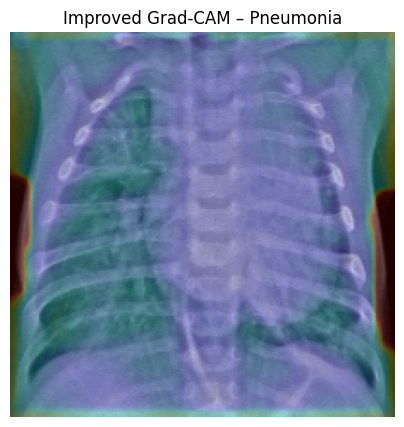

In [6]:
# -------------------------------------------------
# Improved Grad-CAM (border-aware, cleaner)
# -------------------------------------------------

# 1️⃣ Crop image borders (reduce scanner artifacts)
h, w = img.shape
crop = int(0.06 * w)   # 6% crop on left & right
img_cropped = img[:, crop:-crop]

# Resize back to model input
img_cropped = cv2.resize(img_cropped, (224, 224))
img_norm = img_cropped / 255.0
img_array = np.expand_dims(img_norm, axis=(0, -1))

# 2️⃣ Build model graph
_ = model(img_array)

# 3️⃣ Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    last_conv_layer_name="conv2d_4"
)

# 4️⃣ Overlay heatmap with LOWER alpha (important)
overlay = overlay_heatmap(
    cv2.cvtColor(img_cropped, cv2.COLOR_GRAY2BGR),
    heatmap,
    alpha=0.25
)

# 5️⃣ Save Grad-CAM OUTSIDE notebooks folder
save_gradcam(
    image_id="sample_pneumonia_improved",
    overlay=overlay,
    project_root=PROJECT_ROOT
)

# 6️⃣ Display
plt.figure(figsize=(5, 5))
plt.imshow(overlay)
plt.axis("off")
plt.title("Improved Grad-CAM – Pneumonia")
plt.show()
